# Comparison between the mass-conservation constraint and the SHK geodesic

In [Lachos & Mielke (2018)](https://arxiv.org/pdf/1712.01888), it has been proved that the Wasserstein-Fisher-Rao distance can be seen as a cone of the space of probability measures with so-called the **spherical Hellinger-Kantrovich (SHK) distance**. 

We have seen (at least formally) that the SHK space is actually equivalent to the WFR space with the constraint that the total mass is always $1$. Moreover, Lachos & Mielke provides a formula to calculate a geodesic on the SHK space from a geodesic on the unconstrained WFR space. 

In this notebook, we will compare the projected geodesic and the geodesic calculated by our constrained algorithm.


In [1]:
# Import relevant libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation

# The theory

## Conversion of the distance WFR -> SHK
We will consider the WFR distance with $\delta=1$:
$\begin{equation}\textrm{WFR}(\rho_0,\rho_1)^2 = \textrm{inf}\left\{\int_{0}^{1}\int_{\Omega} \frac{\|\omega\|^2 +\zeta^2}{2\rho}dxdt\middle|\partial_t \rho + \nabla\cdot \omega = \zeta, \rho(0)=\rho_0, \rho(1)=\rho_1\right\}\end{equation}$

The Hellinger-Kantrovich distance (Liero et al. 2015) has a slightly different definition, and the above expression is equal to $\frac{1}{2}\textrm{HK}_{1,1}(\rho_0,\rho_1)^2$. That is, we have 

$\begin{equation} \textrm{HK}_{1,1}(\rho_0,\rho_1) = \sqrt{2}\textrm{WFR}(\rho_0,\rho_1)\end{equation}$

Substituting this to the equation from Lachos & Mielke that connects HK & SHK, we have

$\begin{equation} \textrm{SHK}(\nu_0, \nu_1) = \textrm{arccos}\left(1 - \frac{\textrm{WFR}^2(\nu_0,\nu_1)}{4}\right)\end{equation}$

The following code implements this conversion.

In [38]:
def WFR_to_SHK(WFR):
    """ Convert WFR to SHK
    WFR: float, WFR value
    return: float, SHK value"""
    return math.acos(1-WFR**2/4)

## Conversion of a geodesic WFR -> SHK
Lachos & Mielke proved that, given a geodesic in the WFR space, we can project it to the SHK to obtain a geodeseic there. if $\rho$ is a geodesic in the WFR space between $\rho_0,\rho_1$, Theorem 2.7 from Lachos & Mielke shows that $\rho(\beta(t))/r(t)$ is a geodesic between $\bar{\rho}_0=\rho_0/r_0$ and $\bar{\rho}_1 = \rho_1/r_1, r_0=\rho_0(\Omega),r_1=\rho_1(\Omega)$ where

$\begin{align} \beta(t) &= \frac{r_0 \sin \left( t \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right)}{r_1 \sin \left( (1-t) \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right) + r_0 \sin \left( t \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1)\right)} \\ r(t) &=  
\frac{r_0 r_1 \sin \left( \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right)}
{r_1 \sin \left( (1-t) \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right) + r_0 \sin \left( t \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right)}. \end{align}$


The following implements $\beta$ & $r$.

In [39]:
def beta(t, SHK, r0, r1):
    """
    Computes the value of β(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of β(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * np.sin(t * SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in beta(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def r(t, SHK, r0, r1):
    """
    Computes the value of r(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of r(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * r1 * np.sin(SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in r(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

Now, suppose we calculated an unconstrained geodesic $\rho$, and we want to project it to the SHK space. The biggest challange is to find the reparametrization $\rho(\beta(t))$ since $\beta(t)$ is most likely not on our discretized grid. To find the values at such $t$, we simply consider a linear interpolation.

For more accurate interpolation, we can solve the constrained WFR problem such that $\rho_t(\Omega) = r(t)$, but we will not take this approach as the objective here is to compare the constrained WFR algorithm with the theoretical result.

In [42]:
def reparametrize_mass_distributions(mass_distributions, SHK, r0, r1, cs, ll):
    """
    Reparametrize the mass distributions according to the beta(t) function.

    Parameters:
    - mass_distributions (np.ndarray): Array of shape (time_dim, *space_dims)
    - SHK (float): SHK parameter for beta(t)
    - r0 (float): r0 parameter for beta(t)
    - r1 (float): r1 parameter for beta(t)
    - cs (tuple): the size of the spatial grid
    - ll (tuple): the length of the spatial domain

    Returns:
    - np.ndarray: Reparametrized mass distributions of the same shape.
    """
    time_dim = mass_distributions.shape[0]
    T = time_dim - 1

    # Original time grid
    t = np.linspace(0, 1, time_dim)  # t_i = i / T

    # Compute beta(t_i)
    beta_t = beta(t, SHK, r0, r1)

    # Ensure beta_t is within [0, 1]
    beta_t = np.clip(beta_t, 0, 1)

    # Scale beta_t to index space and find lower indices
    beta_scaled = beta_t * T
    k = np.floor(beta_scaled).astype(int)
    k = np.clip(k, 0, T - 1)  # Ensure indices are within valid range

    # Calculate weights for linear interpolation
    t_k = k / T
    t_k1 = (k + 1) / T
    delta_t = t_k1 - t_k
    delta_t[delta_t == 0] = 1e-10  # Avoid division by zero

    w_k1 = (beta_t - t_k) / delta_t
    w_k = 1 - w_k1

    # Reshape weights for broadcasting
    weight_shape = (time_dim,) + (1,) * (mass_distributions.ndim - 1)
    w_k = w_k.reshape(weight_shape)
    w_k1 = w_k1.reshape(weight_shape)

    # Interpolate mass distributions
    mass_k = mass_distributions[k]
    mass_k1 = mass_distributions[k + 1]

    mass_beta_t = w_k * mass_k + w_k1 * mass_k1
    
    # Normalize for each time step
    reshape = (time_dim,) + (1,) * (mass_beta_t.ndim-1)
    mass_beta_t = (mass_beta_t / np.sum(mass_beta_t, axis=tuple(range(1, mass_beta_t.ndim))).reshape(reshape)) * np.prod(cs[1:]) / np.prod(ll[1:])

    return mass_beta_t

# Experiment: Interpolation of mixture of gaussians in 1D

Here, we compare our algorithm and the projected geodesic using the mixture of Gaussians.

In [2]:
def generate_gaussian_mixture(num_gaussians, interval_length, grid_size, sigma=1.0, dimension=2):
    """
    Generates a mixture of Gaussian distributions on an n-dimensional grid.

    Parameters:
    - num_gaussians (int): Number of Gaussian components in the mixture.
    - interval_length (float or list of floats): Length of the interval [0, L] for each dimension.
    - grid_size (int or list of ints): Number of points in the grid per dimension.
    - sigma (float): Standard deviation of the Gaussians.
    - dimension (int): Number of dimensions.

    Returns:
    - grids (list of np.ndarray): List of n-dimensional arrays representing grid points per dimension.
    - p (np.ndarray): n-dimensional array representing the probability distribution on the grid.
    """
    # Ensure interval_length and grid_size are lists with length equal to dimension
    if isinstance(interval_length, (int, float)):
        interval_length = [interval_length] * dimension
    else:
        assert len(interval_length) == dimension, "interval_length must have length equal to dimension"

    if isinstance(grid_size, int):
        grid_size = [grid_size] * dimension
    else:
        assert len(grid_size) == dimension, "grid_size must have length equal to dimension"

    # Create grid points for each dimension
    grids = []
    for d in range(dimension):
        indices = np.arange(grid_size[d])
        grid = (indices + 0.5) / grid_size[d] * interval_length[d]
        grids.append(grid)

    # Create a meshgrid for all dimensions
    mesh = np.meshgrid(*grids, indexing='ij')  # 'ij' indexing for n-dimensional grid

    # Initialize the probability distribution to zero
    p = np.zeros(mesh[0].shape)

    # Generate random means for each Gaussian component
    means = np.random.uniform(0, interval_length, size=(num_gaussians, dimension))
    
    # Generate random weights and normalize them to sum to 1
    weights = np.random.uniform(0, 1, size=num_gaussians)
    weights /= np.sum(weights)  # Optional: Normalize weights if desired

    # Compute each Gaussian component and add it to the mixture
    for mu, w in zip(means, weights):
        # Calculate the squared Euclidean distance from each grid point to the mean
        squared_diff = np.zeros_like(p)
        for d in range(dimension):
            squared_diff += (mesh[d] - mu[d]) ** 2
        
        # Compute the Gaussian function
        gaussian = w * np.exp(-0.5 * squared_diff / (sigma ** 2))
        
        # Add the Gaussian component to the mixture
        p += gaussian

    # Normalize the mixture to form a probability distribution
    p /= np.sum(p)

    return grids, p

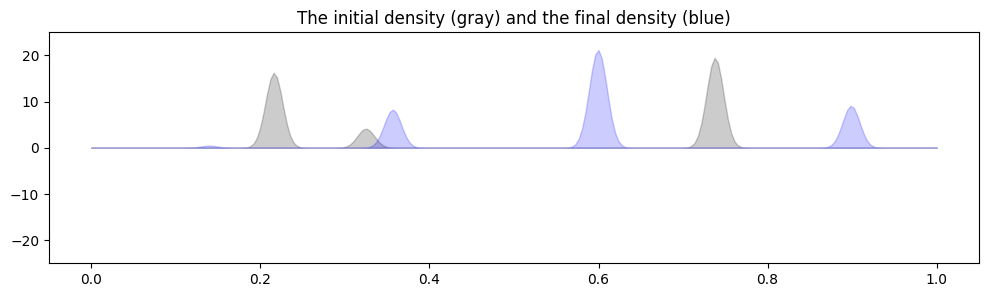

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
WFR: 0.1517365438765018
Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


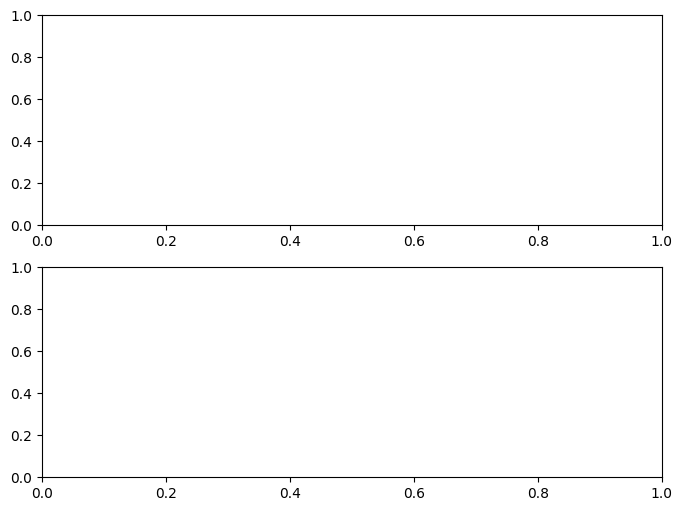

In [108]:
# Define the initial and the terminal distributions
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain
_, rho_0 = generate_gaussian_mixture(3, 1.0, K, sigma=0.01)
_, rho_1 = generate_gaussian_mixture(5, 1.0, K, sigma=0.01)

rho_0 = rho_0 * 256   # Multiplier to make sure it is an unbalanced problem
rho_1 = rho_1 * 256 

#rho_0 = np.load('rho_0_SHK.npy')/5
#rho_1 = np.load('rho_1_SHK.npy')/3

plt.figure(figsize=(12, 3))
plt.ylim(-25, 25)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2) 
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

T = 60
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0), niter = 1000)

WFR = np.sqrt(z.V.energy(1.0, 2.0, 2.0))
print(f"WFR: {WFR}")
SHK = WFR_to_SHK(WFR)
r0 = 1.0
r1 = 1.0

# Reparametrize the mass distributions
reparam_D = reparametrize_mass_distributions(z.U.D[0], SHK, r0, r1, (1, K), (1, 1))

# Calculate the constrained geodesic
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0), np.ones((T, K)), np.ones(T), niter = 1000)

# Set up the figure and axes
ylim = [-25, 25]
fig, axs = plt.subplots(2, 1, figsize=[8, 6])

def init():
    # Initialize the plots
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    return axs

def update(t):
    for ax in axs:
        ax.clear()

    # First subplot for x.U.D
    axs[0].fill_between(X, z.U.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    axs[0].set_title('Comparison - Constrained UOT')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[0].legend()

    # Second subplot for reparam_D
    axs[1].fill_between(X, reparam_D[t, :], color="g", alpha=0.7, label=r'$\rho_{\beta(t)}$')
    axs[1].set_title('Comparison - Projected unconstrained UOT')
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    axs[1].legend()

    return axs

#ani = animation.FuncAnimation(fig, update, frames=range(T), init_func=init, blit=False)

# Save the animation as an MP4 video
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
#ani.save('animation.mp4', writer=writer)

In [109]:
print('L2 difference between the paths', np.linalg.norm(reparam_D - z.U.D[0])/(256*60))
print('L2 difference between rho_0 and rho_1', np.linalg.norm(rho_0-rho_1)/256)
print('Deviation from the continuity equation', z.dist_from_CE())
print('Deviation from the constraint', z.dist_from_constraint(np.ones((T, K)), np.ones(T)))
print('SHK distance by projection', SHK)
print('SHK distance by UOT', np.sqrt(z.V.energy(1.0, 2.0, 2.0, max_ratio = 100)))
print('math.acos(1-WFR**2/2)', math.acos(1-WFR**2/2))

L2 difference between the paths 1.5115056294507359e-05
L2 difference between rho_0 and rho_1 0.2971339865926535
Deviation from the continuity equation 0.01770667522467001
Deviation from the constraint 0.00019385133684336476
SHK distance by projection 0.10734547117454155
SHK distance by UOT 0.1518129149269446
math.acos(1-WFR**2/2) 0.15188248800762963


## Plot of reparametrization $\beta(t)$

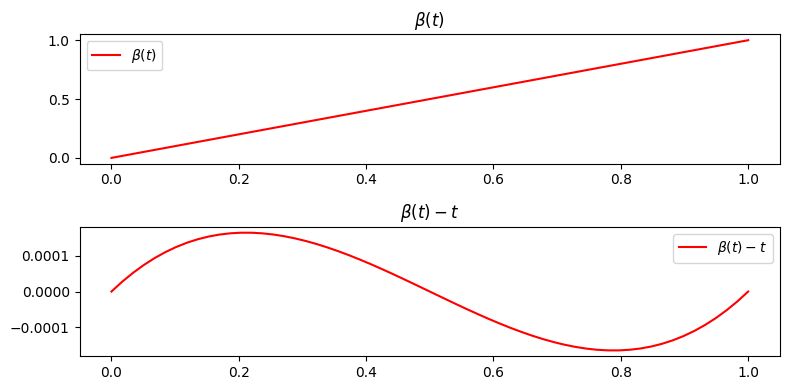

In [107]:
plt.figure(figsize=[8, 4])  # Adjusted the height for two subplots

# First subplot
plt.subplot(2, 1, 1)
plt.title(r'$\beta(t)$')
plt.plot(np.linspace(0, 1, 60), beta(np.linspace(0, 1, 60), SHK, r0, r1), color="r", label=r'$\beta(t)$')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 1, 60), beta(np.linspace(0, 1, 60), SHK, r0, r1) - np.linspace(0, 1, 60), color="r", label=r'$\beta(t) - t$')
plt.title(r'$\beta(t)-t$')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Experiment 2: 2D Case

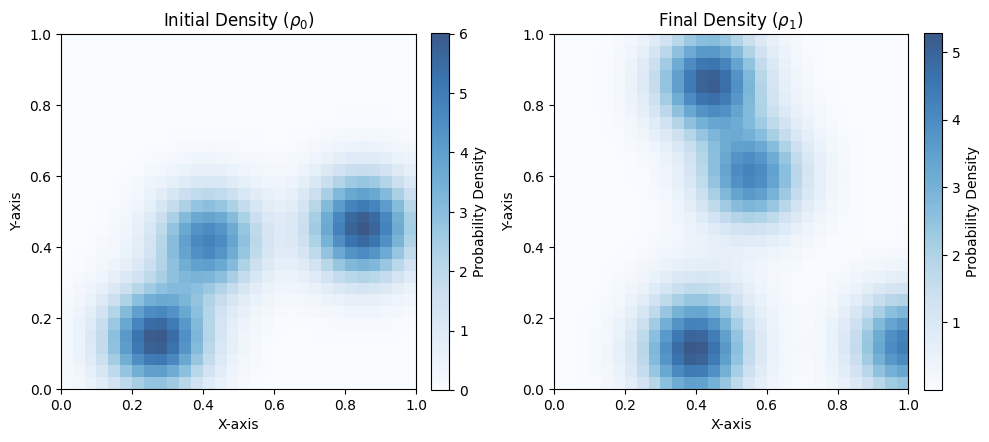

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
WFR: 0.1882756449423647
Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


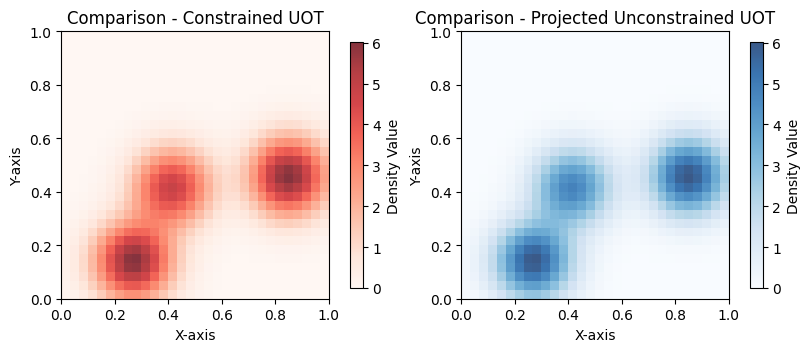

In [72]:
# Define the initial and the terminal distributions
K = 30
interval_length = [1.0, 1.0]  # 2D
grid_size = [K, K]
sigma = 0.1

# Generate 2D Gaussian mixtures
grids, rho_0 = generate_gaussian_mixture(3, interval_length, grid_size, sigma=sigma, dimension=2)
_, rho_1 = generate_gaussian_mixture(5, interval_length, grid_size, sigma=sigma, dimension=2)

# Scale it so that they are DENSITIES, not probabilities
rho_0 = rho_0 * K * K
rho_1 = rho_1 * K * K

# Create meshgrid for plotting
X, Y = grids

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot rho_0
im0 = axs[0].imshow(rho_0, extent=(0, interval_length[0], 0, interval_length[1]),
                    origin='lower', cmap='Blues', alpha=0.8)
axs[0].set_title("Initial Density ($\\rho_0$)")
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label='Probability Density')

# Plot rho_1
im1 = axs[1].imshow(rho_1, extent=(0, interval_length[0], 0, interval_length[1]),
                    origin='lower', cmap='Blues', alpha=0.8)
axs[1].set_title("Final Density ($\\rho_1$)")
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Probability Density')

plt.tight_layout()
plt.show()

T = 60
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0, 1.0), niter = 1000)

WFR = np.sqrt(z.V.energy(1.0, 2.0, 2.0))
print(f"WFR: {WFR}")
SHK = WFR_to_SHK(WFR)
r0 = 1.0
r1 = 1.0

# Reparametrize the mass distributions
reparam_D = reparametrize_mass_distributions(z.U.D[0], SHK, r0, r1, (T, K, K), (1, 1))

# Calculate the constrained geodesic
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0, 1.0), np.ones((T, K, K)), np.ones(T), niter = 1000)

# Set up the figure and axes
ylim = [-25, 25]
fig, axs = plt.subplots(1, 2, figsize=[8, 4], constrained_layout=True)

# Initialize the images
im0 = axs[0].imshow(z.U.D[0][0], extent=(0, interval_length[0], 0, interval_length[1]),
                    origin='lower', cmap='Reds', alpha=0.8)
im1 = axs[1].imshow(reparam_D[0], extent=(0, interval_length[0], 0, interval_length[1]),
                    origin='lower', cmap='Blues', alpha=0.8)

# Set titles and labels
axs[0].set_title('Comparison - Constrained UOT')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

axs[1].set_title('Comparison - Projected Unconstrained UOT')
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')

# Create colorbars only once
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label='Density Value')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Density Value')

def init():
    # Initialization function for the animation
    im0.set_data(z.U.D[0][0])
    im1.set_data(reparam_D[0])
    return [im0, im1]

def update(t):
    # Update function for the animation
    im0.set_data(z.U.D[0][t])
    im1.set_data(reparam_D[t])
    return [im0, im1]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(T), init_func=init, blit=False)

# Save the animation as an MP4 video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('animation2D.mp4', writer=writer)

In [73]:
print('L2 difference between the paths', np.linalg.norm(reparam_D - z.U.D[0])/(256*60))
print('L2 difference between rho_0 and rho_1', np.linalg.norm(rho_0-rho_1)/256)
print('Deviation from the continuity equation', z.dist_from_CE())
print('Deviation from the constraint', z.dist_from_constraint(np.ones((T, K, K)), np.ones(T)))
print('SHK distance by projection', SHK)
print('SHK distance by UOT', np.sqrt(z.V.energy(1.0, 2.0, 2.0, max_ratio = 100)))
print('math.acos(1-WFR**2/2)', math.acos(1-WFR**2/2))

L2 difference between the paths 7.87795859475024e-06
L2 difference between rho_0 and rho_1 0.22894613022242705
Deviation from the continuity equation 2.4201974568938796e-06
Deviation from the constraint 1.1264792753077716e-06
SHK distance by projection 0.13322949827796066
SHK distance by UOT 0.1884135692087235
math.acos(1-WFR**2/2) 0.18855484069672598
